## NVIDIA Nsight Systems
[NVIDIA Nsight™ Systems](https://developer.nvidia.com/nsight-systems) is a system-wide performance analysis tool designed to visualize an application’s algorithms, help to identify the largest opportunities to optimize, and tune to scale efficiently across any quantity or size of CPUs and GPUs.

## NVIDIA Tools Extension (NVTX)

The [NVIDIA® Tools Extension Library (NVTX)](https://github.com/NVIDIA/NVTX) is a powerful mechanism that allows users to manually instrument their application. With a C-based and a python-based Application Programming Interface (API) for annotating events, code ranges, and resources in your applications. Applications which integrate NVTX can use NVIDIA Nsight, Tegra System Profiler, and Visual Profiler to capture and visualize these events and ranges. In general, the NVTX can bring valuable insignt into the application while incurring almost no overhead.


## MONAI Transforms and NVTX
[MONAI](https://github.com/Project-MONAI/MONAI) is a high level framework for deep learning in healthcare imaging. One of its core concepts is [Transforms](https://github.com/Project-MONAI/MONAI/tree/dev/monai/transforms), similar to [TorchVision Transfoms](https://pytorch.org/vision/stable/transforms.html). Several of these transfoms are usualy chained together, using a [Compose](https://github.com/Project-MONAI/MONAI/blob/2f1c7a5d1b47c8dd21681dbe1b67213aa3278cd7/monai/transforms/compose.py#L35) class, to create a preprocessing or postprocessing pipeline that performs manipulation of the input data and make it suitable for training a deep learning model or inference. Using this chain of tranformaion does not allow for insertion of NVTX annotation directly in the code and may require modification of the source code. On the other hand, [MONAI NVTX Tranforms]() are a flexible way to insert the annotations in the chain of transforms by simplly adding additional tranforms that cause vitually no-overhead and does not alter the code.


# Setup Environments

### Install dependencies

In [1]:
!python -c "import monai" || pip install -q git+https://github.com/Project-MONAI/MONAI#egg=MONAI[gdown,ignite,torchvision,cucim]
!python -c "import ignite" || pip install -q pytorch-ignite
!python -c "import torchvision" || pip install -q torchvision
!python -c "import cucim" || pip install -q cucim
!python -c "import pandas" || pip install -q pandas
!python -c "import matplotlib" || pip install -q matplotlib

In [2]:
import os

import gdown
import pandas as pd
from matplotlib import pyplot as plt

### Download data

The pipeline that we are profiling `camelyon_train_evaluate_nvtx_profiling.py` required [Camelyon-16 Challenge](https://camelyon16.grand-challenge.org/) dataset.  You can download all the images for "CAMELYON16" data set from sources listed [here](https://camelyon17.grand-challenge.org/Data/). Also you can find the coordinations and labels for training (`training.csv`) [here](https://drive.google.com/file/d/1httIjgji6U6rMIb0P8pE0F-hXFAuvQEf/view?usp=sharing) and for validation (`validation.csv`) [here](https://drive.google.com/file/d/1tJulzl9m5LUm16IeFbOCoFnaSWoB6i5L/view?usp=sharing).

However, for the demo of this notebook, we are downloading a very small subset of Camelyon dataset, which uses only one whole slide image `tumor_091.tif` .


In [3]:
# Download training.csv
dataset_url = "https://drive.google.com/uc?id=1uWS4CXKD-NP_6-SgiQbQfhFMzbs0UJIr"
dataset_path = "training.csv"
gdown.download(dataset_url, dataset_path, quiet=False)

# Download images
# by default the images expect to be under training/images/
image_dir = os.path.join("training", "images", "")
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
image_url = "https://drive.google.com/uc?id=1OxAeCMVqH9FGpIWpAXSEJe6cLinEGQtF"
gdown.download(image_url, image_dir, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1uWS4CXKD-NP_6-SgiQbQfhFMzbs0UJIr
To: /Users/bhashemian/workspace/tutorials/pathology/tumor_detection/ignite/training.csv
100%|██████████| 153k/153k [00:00<00:00, 1.91MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OxAeCMVqH9FGpIWpAXSEJe6cLinEGQtF
To: /Users/bhashemian/workspace/tutorials/pathology/tumor_detection/ignite/training/images/tumor_091.tif
100%|██████████| 546M/546M [00:22<00:00, 24.1MB/s] 


'training/images/tumor_091.tif'

# Profiling Digital Pathology Tumor Detection Pipeline

In [ ]:
!nsys profile \
    --trace nvtx,osrt,cudnn,cuda, \
    --delay 15 \
    --duration 60 \
    --show-output true \
    --force-overwrite true \
    --output profile_report.nsys-rep \
    python camelyon_train_evaluate_nvtx_profiling.py \
        --cpu 0 \
        --train-file ./training.csv \
        --valid-file ./training.csv \
        --root ./ \
        --bs 10

In [5]:
!nsys stats \
    --report nvtxppsum,nvtxppsum,nvtxpptrace \
    --format table,csv \
    --output -,. \
    --force-overwrite true \
    profile_report.nsys-rep

Generating SQLite file profile_report.sqlite from profile_report.nsys-rep
Exporting 265495 events: [=================================================100%]
Using profile_report.sqlite for SQL queries.
Running [/usr/local/cuda-11.6/NsightSystems-cli-2021.5.2/target-linux-x64/reports/nvtxppsum.py profile_report.sqlite]... 

+----------+-----------------+-----------+--------------+--------------+------------+-------------+--------------+--------------------------+
| Time (%) | Total Time (ns) | Instances |   Avg (ns)   |   Med (ns)   |  Min (ns)  |  Max (ns)   | StdDev (ns)  |          Range           |
+----------+-----------------+-----------+--------------+--------------+------------+-------------+--------------+--------------------------+
|     28.7 |     33706579200 |         5 | 6741315840.0 | 6324451800.0 |  176995000 | 13682363400 | 4889241407.0 | Iteration                |
|     21.3 |     25011936300 |         5 | 5002387260.0 | 4787481900.0 | 2873517700 |  8072929200 | 203549872

# Performance Analysis


In [6]:
# Ordered list of NVTX range for all training transforms
transforms = [
    "ToTensord",
    "Lambdad",
    "GridSplitd",
    "TorchVisiond_ColorJitter",
    "ToNumpyd",
    "RandFlipd",
    "RandRotate90d",
    "CastToTyped",
    "RandZoomd",
    "ScaleIntensityRanged",
    "ToTensord_2",
    "Activationsd",
    "AsDiscreted",
]

## Using Nsight Summary Report

In [7]:
# Load NVTX Push/Pop Range Summary
summary = pd.read_csv("profile_report_nvtxppsum.csv")
# display(summary)

# Set the Range (which is the name of each range) as the index
summary.set_index("Range", inplace=True)

# Get the entries for training transforms only (to avoid nested ranges)
summary = summary.loc[transforms]

# Nsys output column names are different in different versions, 
# so we need to find the corresponding columns
avg_col = [c for c in summary.columns if c.startswith('Av')] 
std_col = [c for c in summary.columns if c.startswith('Std')]
min_col = [c for c in summary.columns if c.startswith('Min')] 
max_col = [c for c in summary.columns if c.startswith('Max')] 

# Normalize each transform range with total average time (percentage of transform time)
summary[["avg%", "std%", 'min%', 'max%']] = summary[avg_col+std_col+min_col+max_col] / summary[avg_col].sum()[0] * 100
summary

,Time (%),Total Time (ns),Instances,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),avg%,std%,min%,max%
Range,,,,,,,,,,,,
ToTensord,0.0,54120900,450,120268.7,100700.0,68500,721200,59828.4,0.222186,0.110528,0.126548,1.332357
Lambdad,0.0,2460800,50,49216.0,39450.0,28700,146100,23219.6,0.090922,0.042896,0.053021,0.269908
GridSplitd,0.0,55917100,50,1118342.0,882450.0,685900,5798000,801880.3,2.066044,1.481407,1.267143,10.711323
TorchVisiond_ColorJitter,19.3,22742525900,450,50538946.4,36570950.0,18874200,202062000,36166736.1,93.366500,66.815037,34.868515,373.292740
ToNumpyd,0.1,91848800,450,204108.4,176450.0,128700,745700,87187.5,0.377073,0.161072,0.237763,1.377619
RandFlipd,0.0,39524100,450,87831.3,45950.0,7600,2748400,153536.8,0.162261,0.283646,0.014040,5.077440
RandRotate90d,0.1,59017500,450,131150.0,82250.0,17400,1050600,123950.6,0.242289,0.228988,0.032145,1.940896
CastToTyped,0.0,51677300,450,114838.4,101350.0,67500,1154000,60160.7,0.212154,0.111142,0.124701,2.131919
RandZoomd,0.3,384269900,450,853933.1,65400.0,21000,22487800,2212634.3,1.577570,4.087658,0.038796,41.544340


Text(0.5, 0, '% of preprocessing time')

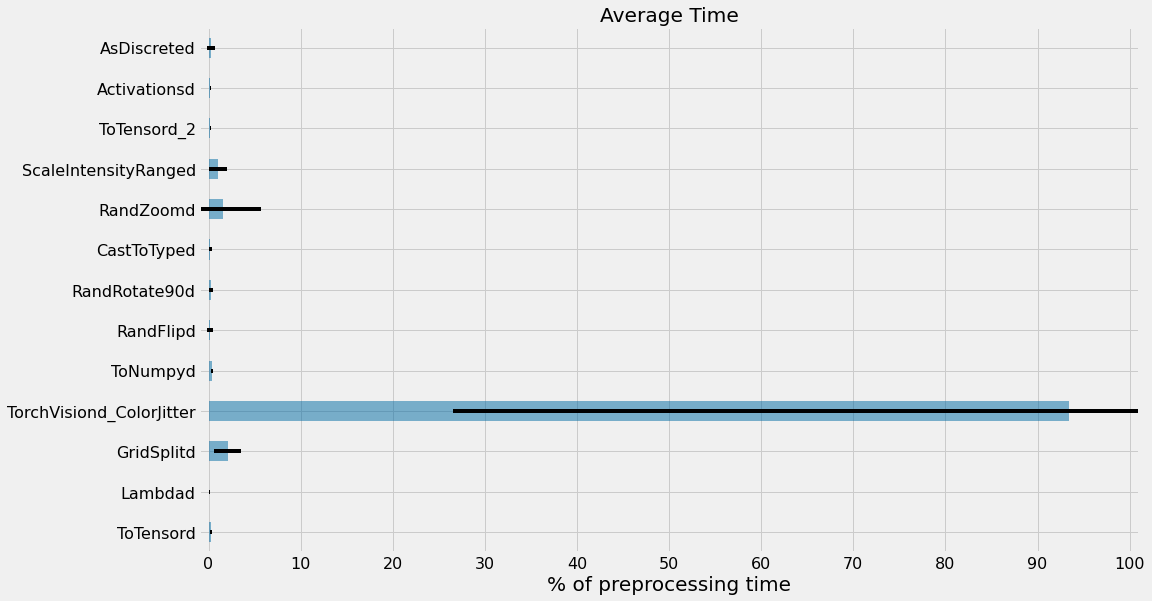

In [8]:
plt.style.use("fivethirtyeight")
plt.style.use("tableau-colorblind10")
axes = summary.plot.barh(
    y="avg%",
    xerr="std%",
    title="Average Time",
    xlabel="",
    fontsize=16,
    figsize=(15, 9),
    alpha=0.5,
    legend="",
)
axes.set_xlim([-1, 101])
axes.set_xticks(range(0, 101, 10))
axes.set_xlabel("% of preprocessing time", fontsize=20)

Text(0.5, 0, '% of preprocessing time')

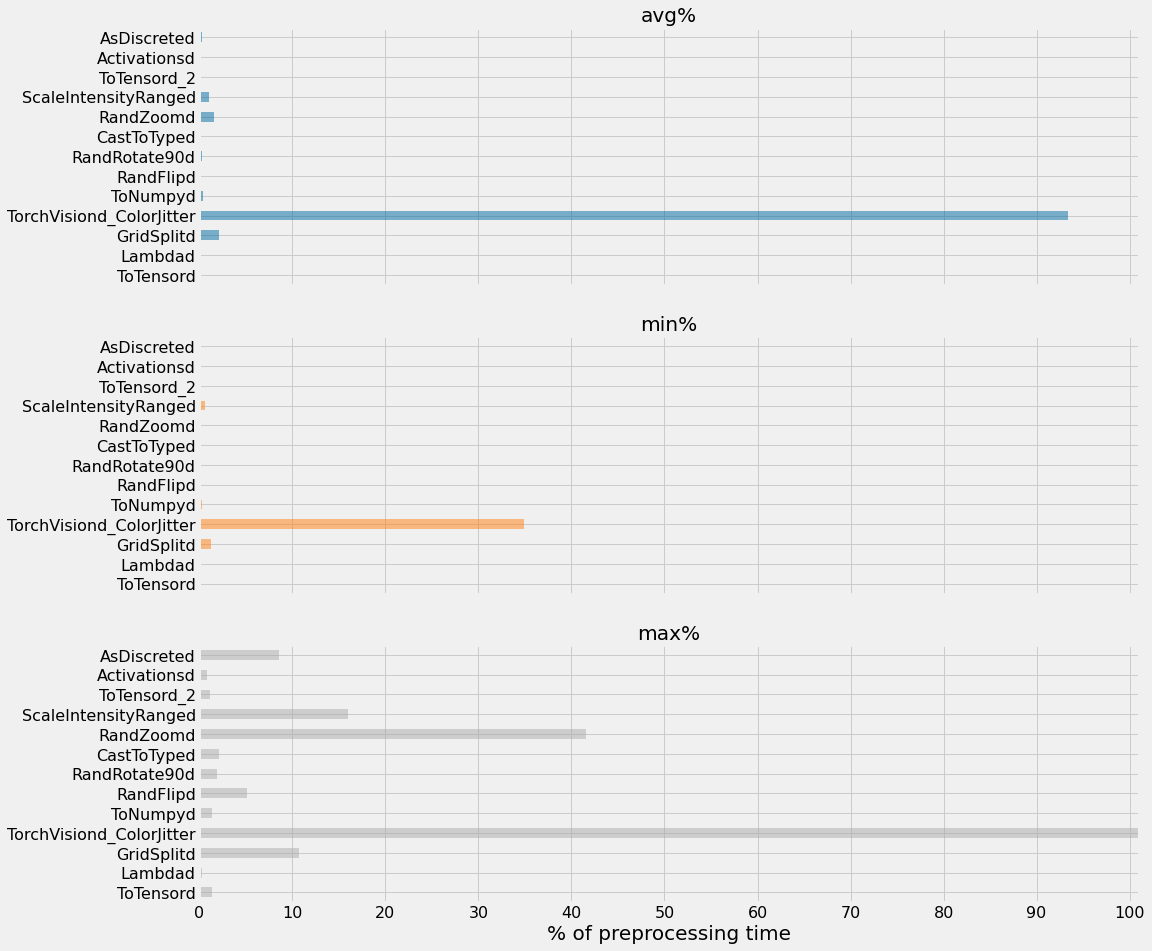

In [9]:
axes = summary.plot.barh(
    y=['avg%', "min%", "max%"],
    xlabel="",
    fontsize=16,
    figsize=(15, 15),
    alpha=0.5,
    subplots=True,
    legend="",
)
axes[-1].set_xlim([0, 101])
axes[-1].set_xticks(range(0, 101, 10))
axes[-1].set_xlabel("% of preprocessing time", fontsize=20)